In [1]:
!pip uninstall tensorflow
!pip install tensorflow==2.1.0
import tensorflow as tf
print(tf.__version__)
print(tf.test.is_gpu_available() == True)

Uninstalling tensorflow-1.15.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/freeze_graph
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-1.15.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
    /usr/local/lib/python3.6/dist-packages/tensorflow_core/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-1.15.0
     |████████████████████████████████| 421.8MB 43kB/s 
     |████████████████████████████████| 450kB 44.6MB/s 
     |████████████████████████████████| 3.9MB 43.4MB/s 
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Succes

In [0]:
!pip install scipy==1.1.0

In [15]:
import tensorflow as tf
print(tf.__version__)
print(tf.test.is_gpu_available() == True)

2.1.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [0]:
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import plot_model
import pandas as pd
from scipy.stats import norm
import pickle as pkl
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob
import scipy

In [0]:
# run params
SECTION = 'paint'
RUN_ID = '0001'
DATA_NAME = 'monet2photo'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' # 'build' # 

In [5]:
!wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/monet2photo.zip

--2020-03-07 06:44:54--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/monet2photo.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 305231073 (291M) [application/zip]
Saving to: ‘monet2photo.zip’

monet2photo.zip     100%[===================>] 291.09M   105MB/s    in 2.8s    

2020-03-07 06:44:57 (105 MB/s) - ‘monet2photo.zip’ saved [305231073/305231073]



In [6]:
!unzip monet2photo.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: monet2photo/trainB/2014-01-10 12:46:39.jpg  
  inflating: monet2photo/trainB/2015-02-23 11:45:00.jpg  
  inflating: monet2photo/trainB/2015-05-23 09:38:08.jpg  
  inflating: monet2photo/trainB/2016-01-15 00:48:49.jpg  
  inflating: monet2photo/trainB/2016-12-27 18:15:26.jpg  
  inflating: monet2photo/trainB/2017-01-02 11:16:05.jpg  
  inflating: monet2photo/trainB/2015-08-06 11:08:32.jpg  
  inflating: monet2photo/trainB/2015-12-16 07:43:36.jpg  
  inflating: monet2photo/trainB/2016-03-25 12:57:28.jpg  
  inflating: monet2photo/trainB/2016-05-10 11:44:44.jpg  
  inflating: monet2photo/trainB/2015-03-11 08:01:52.jpg  
  inflating: monet2photo/trainB/2015-08-30 05:26:05.jpg  
  inflating: monet2photo/trainB/2015-10-03 19:00:56.jpg  
  inflating: monet2photo/trainB/2016-06-08 02:40:47.jpg  
  inflating: monet2photo/trainB/2016-02-28 23:11:19.jpg  
  inflating: monet2photo/trainB/2016-05-03 23:06:27.jpg  
  inflating: monet2photo/trainB/2016

In [0]:
class DataLoader():
    def __init__(self, dataset_name, img_res=(256, 256)):
        self.dataset_name = dataset_name
        self.img_res = img_res

    def load_data(self, domain, batch_size=1, is_testing=False):
        data_type = "train%s" % domain if not is_testing else "test%s" % domain
        path = glob('%s/%s/*' % (self.dataset_name, data_type))
        batch_images = np.random.choice(path, size=batch_size)

        imgs = []
        for img_path in batch_images:
            img = self.imread(img_path)
            if not is_testing:
                img = scipy.misc.imresize(img, self.img_res)

                if np.random.random() > 0.5:
                    img = np.fliplr(img)
            else:
                img = scipy.misc.imresize(img, self.img_res)
            imgs.append(img)

        imgs = np.array(imgs)/127.5 - 1.

        return imgs

    def load_batch(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "val"
        path_A = glob('%s/%sA/*' % (self.dataset_name, data_type))
        path_B = glob('%s/%sB/*' % (self.dataset_name, data_type))

        self.n_batches = int(min(len(path_A), len(path_B)) / batch_size)
        total_samples = self.n_batches * batch_size

        # Sample n_batches * batch_size from each path list so that model sees all
        # samples from both domains
        path_A = np.random.choice(path_A, total_samples, replace=False)
        path_B = np.random.choice(path_B, total_samples, replace=False)

        for i in range(self.n_batches-1):
            batch_A = path_A[i*batch_size:(i+1)*batch_size]
            batch_B = path_B[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for img_A, img_B in zip(batch_A, batch_B):
                img_A = self.imread(img_A)
                img_B = self.imread(img_B)

                img_A = scipy.misc.imresize(img_A, self.img_res)
                img_B = scipy.misc.imresize(img_B, self.img_res)

                if not is_testing and np.random.random() > 0.5:
                        img_A = np.fliplr(img_A)
                        img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)

            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            yield imgs_A, imgs_B

    def load_img(self, path):
        img = self.imread(path)
        img = scipy.misc.imresize(img, self.img_res)
        img = img/127.5 - 1.
        return img[np.newaxis, :, :, :]

    def imread(self, path):
        return scipy.misc.imread(path, mode='RGB').astype(np.float)

In [0]:
IMAGE_SIZE=128
data_loader = DataLoader('monet2photo',img_res=(IMAGE_SIZE,IMAGE_SIZE))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


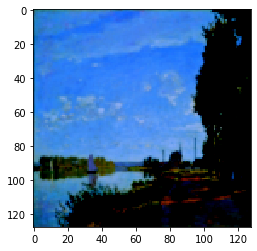

In [43]:
plt.imshow(data_loader.load_data('A')[0])

In [10]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.0MB 4.8MB/s 


In [0]:
from collections import deque
import random
import datetime
import tensorflow_addons as tfa

In [0]:
class ReflectionPadding2D(tf.keras.layers.Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [tf.keras.layers.InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        """ If you are using "channels_last" configuration"""
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

In [0]:
class CycleGAN():
    def __init__(self
        , input_dim
        , learning_rate
        , lambda_validation
        , lambda_reconstr
        , lambda_id
        , generator_type
        , gen_n_filters
        , disc_n_filters
        , buffer_max_length = 50
        ):

        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.buffer_max_length = buffer_max_length
        self.lambda_validation = lambda_validation
        self.lambda_reconstr = lambda_reconstr
        self.lambda_id = lambda_id
        self.generator_type = generator_type
        self.gen_n_filters = gen_n_filters
        self.disc_n_filters = disc_n_filters

        # Input shape
        self.img_rows = input_dim[0]
        self.img_cols = input_dim[1]
        self.channels = input_dim[2]
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        self.d_losses = []
        self.g_losses = []
        self.epoch = 0

        self.buffer_A = deque(maxlen = self.buffer_max_length)
        self.buffer_B = deque(maxlen = self.buffer_max_length)
        
        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**3)
        self.disc_patch = (patch, patch, 1)

        self.weight_init = tf.keras.initializers.RandomNormal(mean=0., stddev=0.02)

        self.compile_models()

        
    def compile_models(self):

        # Build and compile the discriminators
        self.d_A = self.build_discriminator()
        self.d_B = self.build_discriminator()
        
        self.d_A.compile(loss='mse',
            optimizer=tf.keras.optimizers.Adam(self.learning_rate, 0.5),
            metrics=['accuracy'])
        self.d_B.compile(loss='mse',
            optimizer=tf.keras.optimizers.Adam(self.learning_rate, 0.5),
            metrics=['accuracy'])


        # Build the generators
        if self.generator_type == 'unet':
            self.g_AB = self.build_generator_unet()
            self.g_BA = self.build_generator_unet()
        else:
            self.g_AB = self.build_generator_resnet()
            self.g_BA = self.build_generator_resnet()

        # For the combined model we will only train the generators
        self.d_A.trainable = False
        self.d_B.trainable = False

        # Input images from both domains
        img_A = tf.keras.layers.Input(shape=self.img_shape)
        img_B = tf.keras.layers.Input(shape=self.img_shape)

        # Translate images to the other domain
        fake_B = self.g_AB(img_A)
        fake_A = self.g_BA(img_B)
        # Translate images back to original domain
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)
        # Identity mapping of images
        img_A_id = self.g_BA(img_A)
        img_B_id = self.g_AB(img_B)

        # Discriminators determines validity of translated images
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)

        # Combined model trains generators to fool discriminators
        self.combined = tf.keras.Model(inputs=[img_A, img_B],
                                       outputs=[ valid_A, valid_B,
                                                 reconstr_A, reconstr_B,
                                                 img_A_id, img_B_id ])
        self.combined.compile(loss=['mse', 'mse',
                                    'mae', 'mae',
                                    'mae', 'mae'],
                            loss_weights=[  self.lambda_validation,                       self.lambda_validation,
                                            self.lambda_reconstr, self.lambda_reconstr,
                                            self.lambda_id, self.lambda_id ],
                            optimizer=tf.keras.optimizers.Adam(0.0002, 0.5))

        self.d_A.trainable = True
        self.d_B.trainable = True
    

    def build_generator_unet(self):

        def downsample(layer_input, filters, f_size=4):
            d = tf.keras.layers.Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = tfa.layers.InstanceNormalization(axis = -1, center = False, scale = False)(d)
            d = tf.keras.layers.Activation('relu')(d)
            
            return d

        def upsample(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            u = tf.keras.layers.UpSampling2D(size=2)(layer_input)
            u = tf.keras.layers.Conv2D(filters, kernel_size=f_size, strides=1, padding='same')(u)
            u = tfa.layers.InstanceNormalization(axis = -1, center = False, scale = False)(u)
            u = tf.keras.layers.Activation('relu')(u)
            if dropout_rate:
                u = tf.keras.layers.Dropout(dropout_rate)(u)

            u = tf.keras.layers.Concatenate()([u, skip_input])
            return u

        # Image input
        img = tf.keras.layers.Input(shape=self.img_shape)

        # Downsampling
        d1 = downsample(img, self.gen_n_filters) 
        d2 = downsample(d1, self.gen_n_filters*2)
        d3 = downsample(d2, self.gen_n_filters*4)
        d4 = downsample(d3, self.gen_n_filters*8)

        # Upsampling
        u1 = upsample(d4, d3, self.gen_n_filters*4)
        u2 = upsample(u1, d2, self.gen_n_filters*2)
        u3 = upsample(u2, d1, self.gen_n_filters)

        u4 = tf.keras.layers.UpSampling2D(size=2)(u3)
        output_img = tf.keras.layers.Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u4)

        return tf.keras.Model(img, output_img)


    def build_generator_resnet(self):

        def conv7s1(layer_input, filters, final):
            y = ReflectionPadding2D(padding =(3,3))(layer_input)
            y = tf.keras.layers.Conv2D(filters, kernel_size=(7,7), strides=1, padding='valid', kernel_initializer = self.weight_init)(y)
            if final:
                y = tf.keras.layers.Activation('tanh')(y)
            else:
                y = tfa.layers.InstanceNormalization(axis = -1, center = False, scale = False)(y)
                y = tf.keras.layers.Activation('relu')(y)
            return y

        def downsample(layer_input,filters):
            y = tf.keras.layers.Conv2D(filters, kernel_size=(3,3), strides=2, padding='same', kernel_initializer = self.weight_init)(layer_input)
            y = tfa.layers.InstanceNormalization(axis = -1, center = False, scale = False)(y)
            y = tf.keras.layers.Activation('relu')(y)
            return y

        def residual(layer_input, filters):
            shortcut = layer_input
            y = ReflectionPadding2D(padding =(1,1))(layer_input)
            y = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=1, padding='valid', kernel_initializer = self.weight_init)(y)
            y = tfa.layers.InstanceNormalization(axis = -1, center = False, scale = False)(y)
            y = tf.keras.layers.Activation('relu')(y)
            
            y = ReflectionPadding2D(padding =(1,1))(y)
            y = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=1, padding='valid', kernel_initializer = self.weight_init)(y)
            y = tfa.layers.InstanceNormalization(axis = -1, center = False, scale = False)(y)

            return tf.keras.layers.add([shortcut, y])

        def upsample(layer_input,filters):
            y = tf.keras.layers.Conv2DTranspose(filters, kernel_size=(3, 3), strides=2, padding='same', kernel_initializer = self.weight_init)(layer_input)
            y = tfa.layers.InstanceNormalization(axis = -1, center = False, scale = False)(y)
            y = tf.keras.layers.Activation('relu')(y)
    
            return y


        # Image input
        img = tf.keras.layers.Input(shape=self.img_shape)

        y = img

        y = conv7s1(y, self.gen_n_filters, False)
        y = downsample(y, self.gen_n_filters * 2)
        y = downsample(y, self.gen_n_filters * 4)
        y = residual(y, self.gen_n_filters * 4)
        y = residual(y, self.gen_n_filters * 4)
        y = residual(y, self.gen_n_filters * 4)
        y = residual(y, self.gen_n_filters * 4)
        y = residual(y, self.gen_n_filters * 4)
        y = residual(y, self.gen_n_filters * 4)
        y = residual(y, self.gen_n_filters * 4)
        y = residual(y, self.gen_n_filters * 4)
        y = residual(y, self.gen_n_filters * 4)
        y = upsample(y, self.gen_n_filters * 2)
        y = upsample(y, self.gen_n_filters)
        y = conv7s1(y, 3, True)
        output = y

   
        return tf.keras.Model(img, output)


    def build_discriminator(self):

        def conv4(layer_input,filters, stride = 2, norm=True):
            y = tf.keras.layers.Conv2D(filters, kernel_size=(4,4), strides=stride, padding='same', kernel_initializer = self.weight_init)(layer_input)
            
            if norm:
                y = tfa.layers.InstanceNormalization(axis = -1, center = False, scale = False)(y)

            y = tf.keras.layers.LeakyReLU(0.2)(y)
           
            return y

        img = tf.keras.layers.Input(shape=self.img_shape)

        y = conv4(img, self.disc_n_filters, stride = 2, norm = False)
        y = conv4(y, self.disc_n_filters*2, stride = 2)
        y = conv4(y, self.disc_n_filters*4, stride = 2)
        y = conv4(y, self.disc_n_filters*8, stride = 1)

        output = tf.keras.layers.Conv2D(1, kernel_size=4, strides=1, padding='same',kernel_initializer = self.weight_init)(y)

        return tf.keras.Model(img, output)

    def train_discriminators(self, imgs_A, imgs_B, valid, fake):

        # Translate images to opposite domain
        fake_B = self.g_AB.predict(imgs_A)
        fake_A = self.g_BA.predict(imgs_B)

        self.buffer_B.append(fake_B)
        self.buffer_A.append(fake_A)

        fake_A_rnd = random.sample(self.buffer_A, min(len(self.buffer_A), len(imgs_A)))
        fake_B_rnd = random.sample(self.buffer_B, min(len(self.buffer_B), len(imgs_B)))

        # Train the discriminators (original images = real / translated = Fake)
        dA_loss_real = self.d_A.train_on_batch(imgs_A, valid)
        dA_loss_fake = self.d_A.train_on_batch(fake_A_rnd, fake)
        dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

        dB_loss_real = self.d_B.train_on_batch(imgs_B, valid)
        dB_loss_fake = self.d_B.train_on_batch(fake_B_rnd, fake)
        dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

        # Total disciminator loss
        d_loss_total = 0.5 * np.add(dA_loss, dB_loss)

        return (
            d_loss_total[0]
            , dA_loss[0], dA_loss_real[0], dA_loss_fake[0]
            , dB_loss[0], dB_loss_real[0], dB_loss_fake[0]
            , d_loss_total[1]
            , dA_loss[1], dA_loss_real[1], dA_loss_fake[1]
            , dB_loss[1], dB_loss_real[1], dB_loss_fake[1]
        )

    def train_generators(self, imgs_A, imgs_B, valid):

        # Train the generators
        return self.combined.train_on_batch([imgs_A, imgs_B],
                                                [valid, valid,
                                                imgs_A, imgs_B,
                                                imgs_A, imgs_B])


    def train(self, data_loader, run_folder, epochs, test_A_file, test_B_file, batch_size=1, sample_interval=50):
        
        start_time = datetime.datetime.now()
        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)
        for epoch in range(self.epoch, epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(data_loader.load_batch()):
                d_loss = self.train_discriminators(imgs_A, imgs_B, valid, fake)
                g_loss = self.train_generators(imgs_A, imgs_B, valid)

                elapsed_time = datetime.datetime.now() - start_time

                # Plot the progress
                if batch_i % 100 == 0:
                    print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %05f, adv: %05f, recon: %05f, id: %05f] time: %s " \
                        % ( self.epoch, epochs,
                            batch_i, data_loader.n_batches,
                            d_loss[0], 100*d_loss[7],
                            g_loss[0],
                            np.sum(g_loss[1:3]),
                            np.sum(g_loss[3:5]),
                            np.sum(g_loss[5:7]),
                            elapsed_time))

                self.d_losses.append(d_loss)
                self.g_losses.append(g_loss)

                # If at save interval => save generated image samples
                if batch_i % sample_interval == 0:
                    self.sample_images(data_loader, batch_i, run_folder, test_A_file, test_B_file)
                    self.combined.save_weights(os.path.join(run_folder, 'weights/weights-%d.h5' % (self.epoch)))
                    self.combined.save_weights(os.path.join(run_folder, 'weights/weights.h5'))
                    self.save_model(run_folder)

                
            self.epoch += 1

    def sample_images(self, data_loader, batch_i, run_folder, test_A_file, test_B_file):
        
        r, c = 2, 4

        for p in range(2):

            if p == 1:
                imgs_A = data_loader.load_data(domain="A", batch_size=1, is_testing=True)
                imgs_B = data_loader.load_data(domain="B", batch_size=1, is_testing=True)
            else:
                imgs_A = data_loader.load_img('%s/testA/%s' % (data_loader.dataset_name, test_A_file))
                imgs_B = data_loader.load_img('%s/testB/%s' % (data_loader.dataset_name, test_B_file))

            # Translate images to the other domain
            fake_B = self.g_AB.predict(imgs_A)
            fake_A = self.g_BA.predict(imgs_B)
            # Translate back to original domain
            reconstr_A = self.g_BA.predict(fake_B)
            reconstr_B = self.g_AB.predict(fake_A)

            # ID the images
            id_A = self.g_BA.predict(imgs_A)
            id_B = self.g_AB.predict(imgs_B)

            gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, id_A, imgs_B, fake_A, reconstr_B, id_B])

            # Rescale images 0 - 1
            gen_imgs = 0.5 * gen_imgs + 0.5
            gen_imgs = np.clip(gen_imgs, 0, 1)

            titles = ['Original', 'Translated', 'Reconstructed', 'ID']
            fig, axs = plt.subplots(r, c, figsize=(25,12.5))
            cnt = 0
            for i in range(r):
                for j in range(c):
                    axs[i,j].imshow(gen_imgs[cnt])
                    axs[i, j].set_title(titles[j])
                    axs[i,j].axis('off')
                    cnt += 1
            fig.savefig(os.path.join(run_folder ,"images/haggie%d_%d_%d.png" % (p, self.epoch, batch_i)))
            plt.close()


    def plot_model(self, run_folder):
        plot_model(self.combined, to_file=os.path.join(run_folder ,'viz/combined.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.d_A, to_file=os.path.join(run_folder ,'viz/d_A.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.d_B, to_file=os.path.join(run_folder ,'viz/d_B.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.g_BA, to_file=os.path.join(run_folder ,'viz/g_BA.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.g_AB, to_file=os.path.join(run_folder ,'viz/g_AB.png'), show_shapes = True, show_layer_names = True)


    def save(self, folder):

        with open(os.path.join(folder, 'params.pkl'), 'wb') as f:
            pkl.dump([
                self.input_dim
                ,  self.learning_rate
                ,  self.buffer_max_length
                ,  self.lambda_validation
                ,  self.lambda_reconstr
                ,  self.lambda_id
                ,  self.generator_type
                ,  self.gen_n_filters
                ,  self.disc_n_filters
                ], f)

        self.plot_model(folder)


    def save_model(self, run_folder):


        self.combined.save_weights(os.path.join(run_folder, 'model.h5')  )
        self.d_A.save_weights(os.path.join(run_folder, 'd_A.h5') )
        self.d_B.save_weights(os.path.join(run_folder, 'd_B.h5') )
        self.g_BA.save_weights(os.path.join(run_folder, 'g_BA.h5')  )
        self.g_AB.save_weights(os.path.join(run_folder, 'g_AB.h5') )

        #pkl.dump(self, open( os.path.join(run_folder, "obj.pkl"), "wb" ))

    def load_weights(self, filepath):
        self.combined.load_weights(filepath)


In [0]:
gan = CycleGAN(
        input_dim = (IMAGE_SIZE,IMAGE_SIZE,3)
        , learning_rate = 0.0002
        , lambda_validation = 1
        , lambda_reconstr = 10
        , lambda_id = 5
        , generator_type = 'resnet'
        , gen_n_filters = 32
        , disc_n_filters = 64
        )

if mode == 'build':
    gan.save(RUN_FOLDER)
else:
    gan.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

In [0]:
BATCH_SIZE = 1
EPOCHS = 3
PRINT_EVERY_N_BATCHES = 10

TEST_A_FILE = '00490.jpg'
TEST_B_FILE = '2014-08-02 15:56:41.jpg'

In [35]:
gan.train(data_loader
        , run_folder = RUN_FOLDER
        , epochs=EPOCHS
        , test_A_file = TEST_A_FILE
        , test_B_file = TEST_B_FILE
        , batch_size=BATCH_SIZE
        , sample_interval=PRINT_EVERY_N_BATCHES)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


[Epoch 0/3] [Batch 0/1072] [D loss: 1.849609, acc:  44%] [G loss: 18.022999, adv: 3.789119, recon: 0.948068, id: 0.950640] time: 0:00:28.721257 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: `imresize` is deprecated!
`imresi

[Epoch 0/3] [Batch 100/1072] [D loss: 0.352112, acc:  49%] [G loss: 8.954056, adv: 1.226152, recon: 0.523747, id: 0.498086] time: 0:01:18.794136 


KeyboardInterrupt: ignored